## Task 1

### This program builds a quantum circuit for that accepts any vector of size $4$ and encodes the data using qRAM and finds the address of data which doesn't have similar digits consicutively. 

#### Since finding $2$ marked solutions in the array of $4$ is impossible using grover's algorithm. Here we used a trich which uses $3$ qbits for address so storing $2^{3}=8$ data points (While measuring we just measure required two). Remaining 4 dummy data points are initiated as $0$ (Doesn't make any difference) 

In [1]:
# Importing standard Qiskit libraries
from qiskit import IBMQ
from qiskit.tools.jupyter import *

# Loading your IBM Quantum account
IBMQ.load_account()
IBMQ.providers() # see a list of providers you have access to

[<AccountProvider for IBMQ(hub='ibm-q', group='open', project='main')>]

In [2]:
import numpy as np
from qiskit import QuantumRegister, ClassicalRegister, QuantumCircuit
from qiskit import IBMQ, Aer, execute
from qiskit.visualization import plot_bloch_multivector
# import basic plot tools
from qiskit.tools.visualization import plot_histogram

In [3]:
input_st = [1,5,7,10]  #change input here

#passing in to binary representation
bin_pass = []
for num in input_st:
    bin_pass.append('{0:04b}'.format(num))
for i in range(4):
    bin_pass.append('0000')             #appending the rest of zeroes (dummy data)

bin_pass

['0001', '0101', '0111', '1010', '0000', '0000', '0000', '0000']

In [4]:
# Defining Oracle which checks for th
def oracle(qc,data,comput):
    #xor of first two digits
    qc.cx(data[0], comput[0])
    qc.cx(data[1], comput[0])

    #xor of digit 1 and 2
    qc.cx(data[1], comput[1])
    qc.cx(data[2], comput[1])

    #xor of digit 2 and 3
    qc.cx(data[2], comput[2])
    qc.cx(data[3], comput[2])
    qc.barrier()

In [5]:
def diffuser(nqubits):
    qc = QuantumCircuit(nqubits)
    # Apply transformation |s> -> |00..0> (H-gates)
    for qubit in range(nqubits):
        qc.h(qubit)
    # Apply transformation |00..0> -> |11..1> (X-gates)
    for qubit in range(nqubits):
        qc.x(qubit)
    # Do multi-controlled-Z gate
    qc.h(nqubits-1)
    qc.mct(list(range(nqubits-1)), nqubits-1)  # multi-controlled-toffoli
    qc.h(nqubits-1)
    # Apply transformation |11..1> -> |00..0>
    for qubit in range(nqubits):
        qc.x(qubit)
    # Apply transformation |00..0> -> |s>
    for qubit in range(nqubits):
        qc.h(qubit)
    # We will return the diffuser as a gate
    U_s = qc.to_gate()
    U_s.name = "$U_s$"
    return U_s

In [6]:
address = QuantumRegister(3)
data = QuantumRegister(4)
comput = QuantumRegister(3)
flag = QuantumRegister(1)
# c = ClassicalRegister(4) #Only measuring the qRAM data
c = ClassicalRegister(2) #Only measuring the qRAM address
# c = ClassicalRegister(3) #Only measuring the comput and qRAM address
anicilla_qubit = QuantumRegister(2)
qRAM_ancilla = QuantumRegister(1)
qc = QuantumCircuit(address,data,qRAM_ancilla,comput,flag,anicilla_qubit,c)

In [7]:
qc.x(flag[0]) #Flag for qram check
qc.h(flag[0])
# address preparation
qc.h([address[0],address[1],address[2]])
qc.barrier()


for l in range(1):
    #qRAM starts here
    for k in range(2):
        for j in range(2):
            for i in range(2):
                qc.barrier()
                flagi = flagj = flagk= 0
                if i==0:
                    qc.x([address[0]])
                    flagi=1
                if j==0:
                    qc.x([address[1]])
                    flagj=1                    
                if k==0:
                    qc.x([address[2]])
                    flagk=1
                for m in range(4):
                    if bin_pass[4*k+2*j+1*i][m]=='1':
                        qc.mct(address,data[m],qRAM_ancilla,mode='basic')
                if flagi==1:
                    qc.x([address[0]])
                if flagj==1:
                    qc.x([address[1]])                
                if flagk==1:
                    qc.x([address[2]])   
#     qc.measure(data[:], c) #to check working of qRAM
    #initiating the data = zero in the rest memory
    qc.barrier()
    oracle(qc,data,comput)
    qc.barrier()
    # mct to see if we are getting 111
    qc.mct(comput,flag[0],anicilla_qubit,mode='basic')
    qc.barrier()
    oracle(qc,data,comput)
    qc.barrier()
#     #qRAM again for uncomputation 
    #qRAM starts here
    for k in range(2):
        for j in range(2):
            for i in range(2):
                qc.barrier()
                flagi = flagj = flagk= 0
                if i==0:
                    qc.x([address[0]])
                    flagi=1
                if j==0:
                    qc.x([address[1]])
                    flagj=1                    
                if k==0:
                    qc.x([address[2]])
                    flagk=1
                for m in range(4):
                    if bin_pass[4*k+2*j+1*i][m]=='1':
                        qc.mct(address,data[m],qRAM_ancilla,mode='basic')
                if flagi==1:
                    qc.x([address[0]])
                if flagj==1:
                    qc.x([address[1]])                
                if flagk==1:
                    qc.x([address[2]]) 
    qc.barrier()
    qc.append(diffuser(3),[0,1,2])
    
qc.barrier()
# qc = qc.reverse_bits()
qc.measure(address[0:2], c)

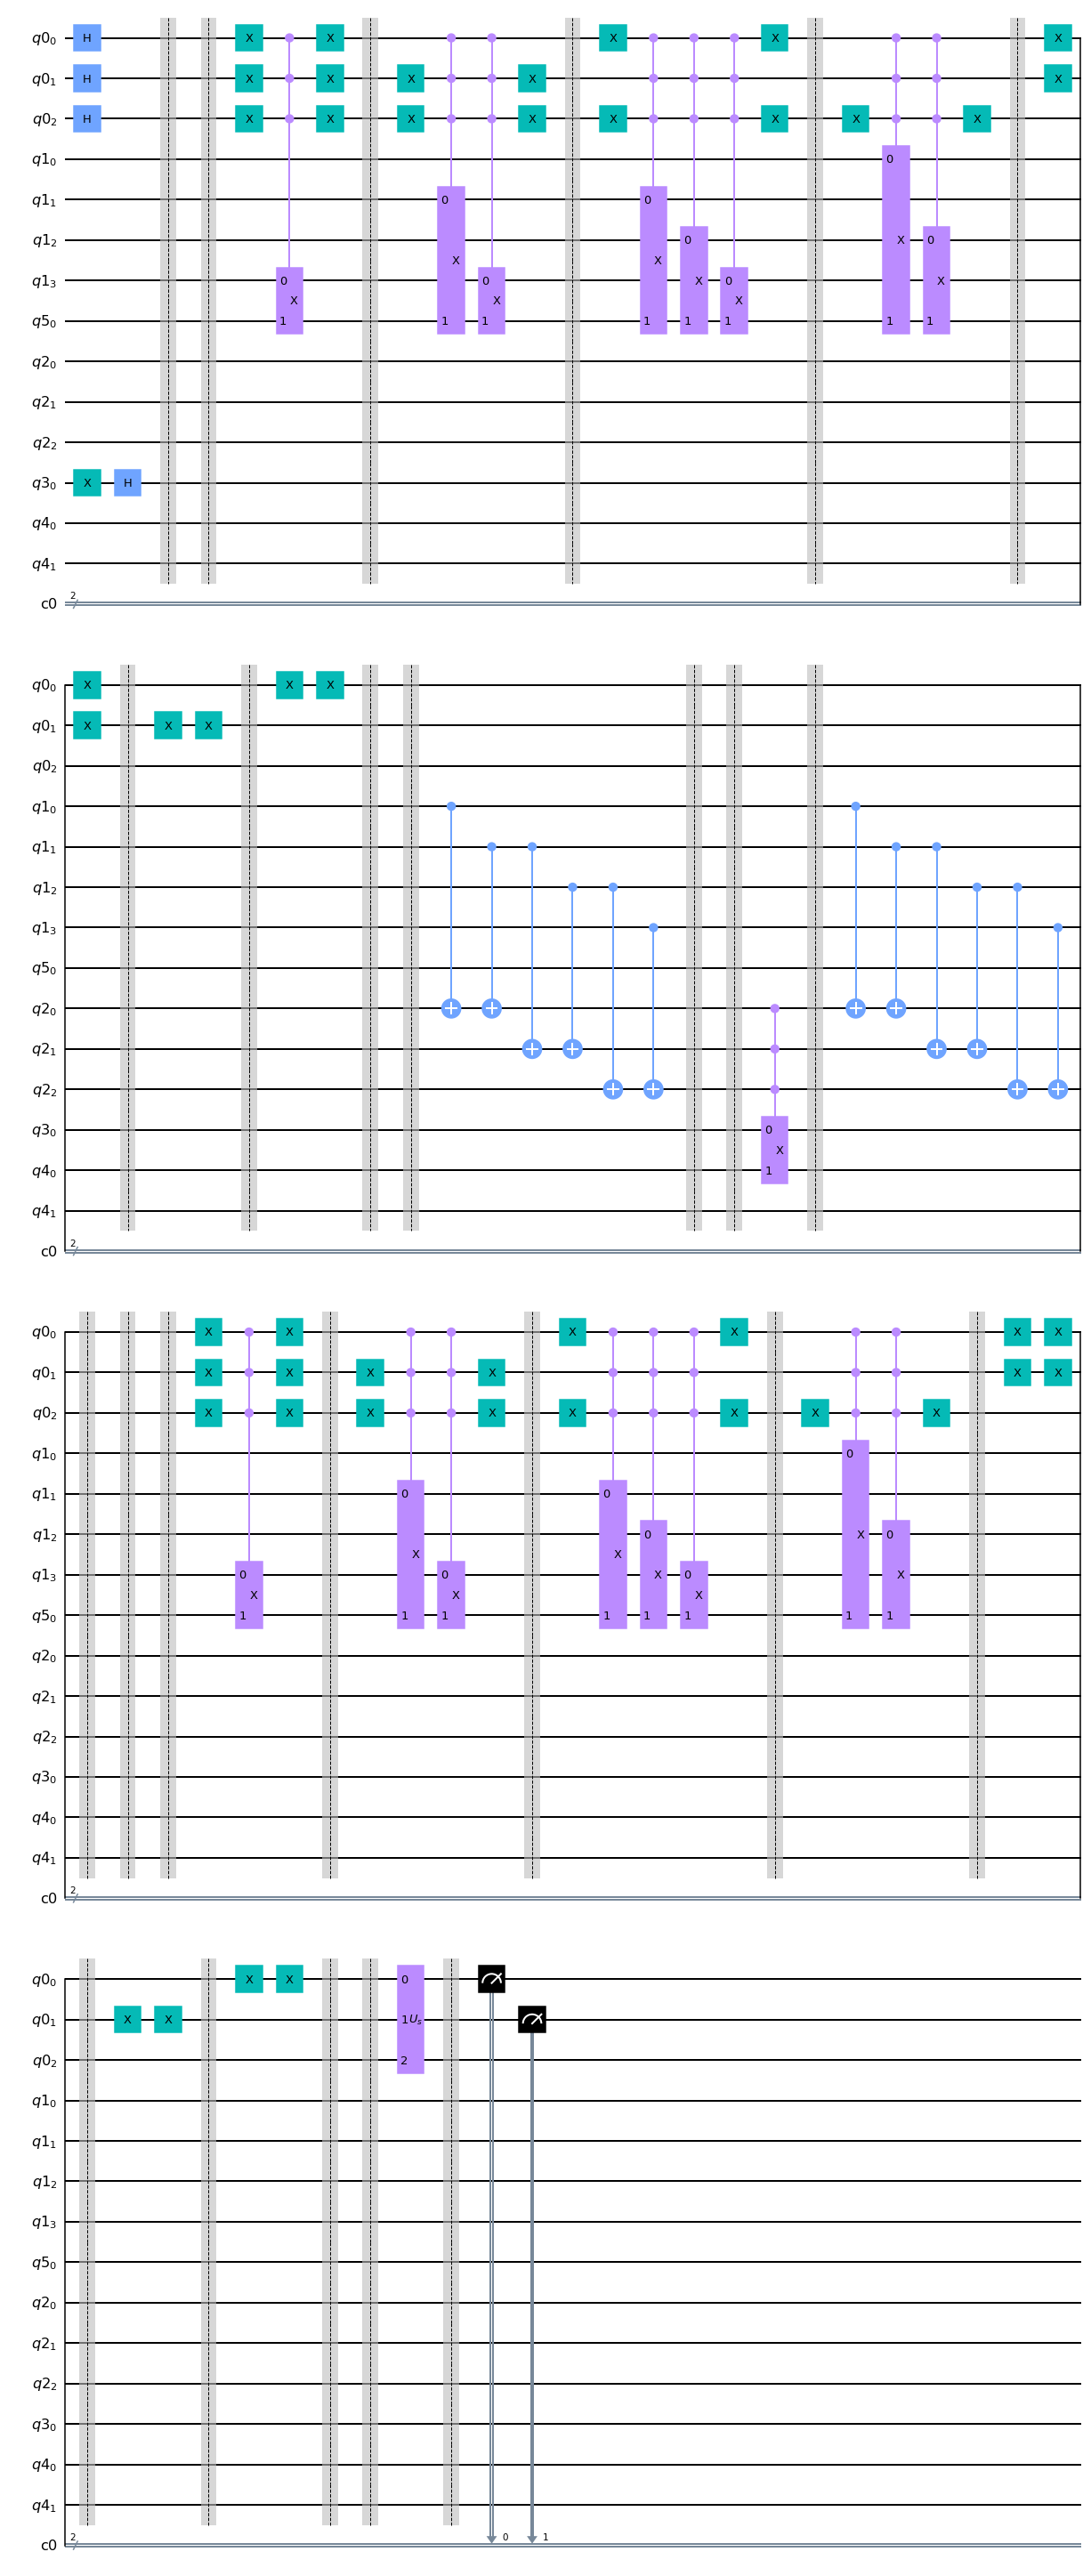

In [8]:
qc.draw(output='mpl')

C:\Users\sumit\miniconda3\envs\ibmqiskit\lib\site-packages\qiskit\execute_function.py:399: DeprecationWarning: Using `backend_options` kwarg has been deprecated as of qiskit-aer 0.7.0 and will be removed no earlier than 3 months from that release date. Runtime backend options should now be added directly using kwargs for each option.
  job = backend.run(experiments, **run_kwargs)


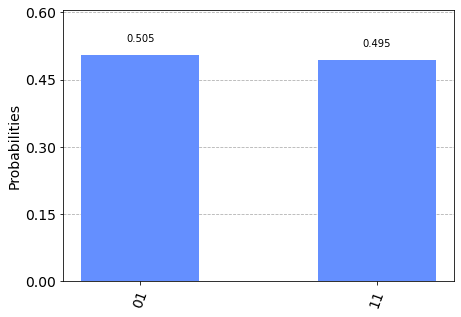

In [9]:
backend = Aer.get_backend('qasm_simulator')
job = execute(qc, backend=backend, shots=8192, seed_simulator=12345, backend_options={"fusion_enable":True})
#job = execute(qc, backend=backend, shots=8192)
result = job.result()
count =result.get_counts()
plot_histogram(result.get_counts())

In [10]:
count

{'01': 4139, '11': 4053}

In [11]:
print('This was the given input\n',input_st)
print('{0:04b}'.format(5),'{0:04b}'.format(10))

This was the given input
 [1, 5, 7, 10]
0101 1010
